In [1]:
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('/content/gdrive/MyDrive/2022-1/휴먼프밍/1차 프로젝트/1주차/train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/2022-1/휴먼프밍/1차 프로젝트/1주차/test.csv')
df_train['FamilySize'] = df_train['SibSp']+df_train['Parch']+1
df_test['FamilySize'] = df_test['SibSp']+df_train['Parch']+1

df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()                        # ??

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

# 3. Feature engineering

* dataset에 있는 null data 채우기 -> 아이디어 필요, feature statistics 참고

## 3.1. Fill Null

### 3.1.1. Fill Null in Age using title

* Age의 null data : 177개 -> title, statistics 사용
* 탑승객 이름의 title (Miss, Mr, Mrs) 사용
* pandas series - str method (data를 string으로 변환), extract method (string에 정규표현식을 적용) --> title 추출하여 Initial column에 저장

In [3]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')                  #extract the Salutations
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1,Mr


In [5]:
# pandas - crosstab : Initial과 Sex 간의 count

pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')            # Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [6]:
# replace method : 특정 데이터 값을 원하는 값으로 치환 ; 여성, 남성이 쓰는 initial 구분

df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], inplace=True)

In [7]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


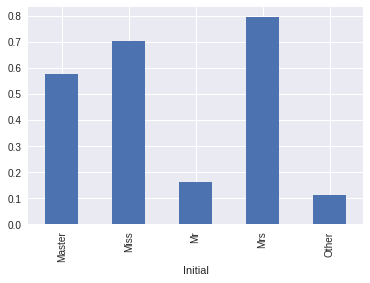

In [8]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

* null data 채우기 ; train data의 statistics 활용 (test는 unseen으로 둬야함, train의 statistics로 train, test의 null data 채워줌

In [9]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [10]:
# Age의 평균 이용해서 null data 채우기
# pandas dataframe -> boolean array를 이용해 indexing하는 것이 편리함
# loc + boolean + column 이용해 값 치환 -> 자주 쓰임

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33           # isnull + Initial이 Mr => 조건 만족하는 row의 'Age'값을 33으로 치환
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46


### 3.1.2. Fill Null in Embarked

* Embarked의 Null value : 2개, S에서 가장 많은 탑승객 -> Null을 S로 채움

In [11]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


In [12]:
# dataframe - fillna method 사용 : inplace=True ; df_train에 fillna 실제로 적용

df_train['Embarked'].fillna('S',inplace=True)

## 3.2. Change Age (continuous to categorical)

* Age = continuous feature  ---> Age를 구간으로 나누어 category화 (단점 : information loss 발생)

* dataframe indexing - loc 사용
* apply 함수 사용

In [13]:
# loc 사용, 10살 간격

df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10<=df_train['Age']) & (df_train['Age']<20), 'Age_cat'] =1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] =1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

In [14]:
# apply method : 간단한 함수 적용

def category_age(x):
  if x < 10:
    return 0
  elif x < 20:
    return 1
  elif x < 30:
    return 2
  elif x < 40:
    return 3
  elif x < 50:
    return 4
  elif x < 60:
    return 5
  elif x < 70:
    return 6
  else:
    return 7


df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [15]:
# loc, apply 비교 --> Series 간 boolean 비교 후 all() 메소드 사용 --> all() : 모든 값이 true 면 True, 하나라도 false면 False 반환

print('1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 반환 ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘 다 같은 결과를 내면 True 반환 -> True


In [16]:
# Age, Age_cat_2 제거

df_train.drop(['Age','Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3. Change Initial, Embarked and Sex (String to numerical)

* Initial -> Mr, Mrs, Miss, Master, Other : 카테고리형 데이터 -> 수치화 필요
* map method 사용

In [24]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

* Embarked -> C, Q, S -> map을 이용해 수치화
* 특정 column에 어떤 값이 있는지 확인하는 방법 : unique(), value_counts()

In [17]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [20]:
# 'Embarked'에 Null 없는지 확인 -> isnull().any()

df_train['Embarked'].isnull().any()

False

In [21]:
# mapping 'Sex'

df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

* 각 feature 간 상관관계 보기 : 두 변수가의 pearson correlation 구하기 (-1,1) 사이 값 얻음
* 수식 : 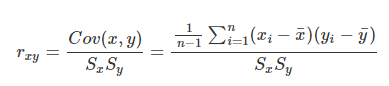

* 여러 feature를 하나의 matrix로 보는 방법 : heatmap plot -> corr() method와 seaborn 사용

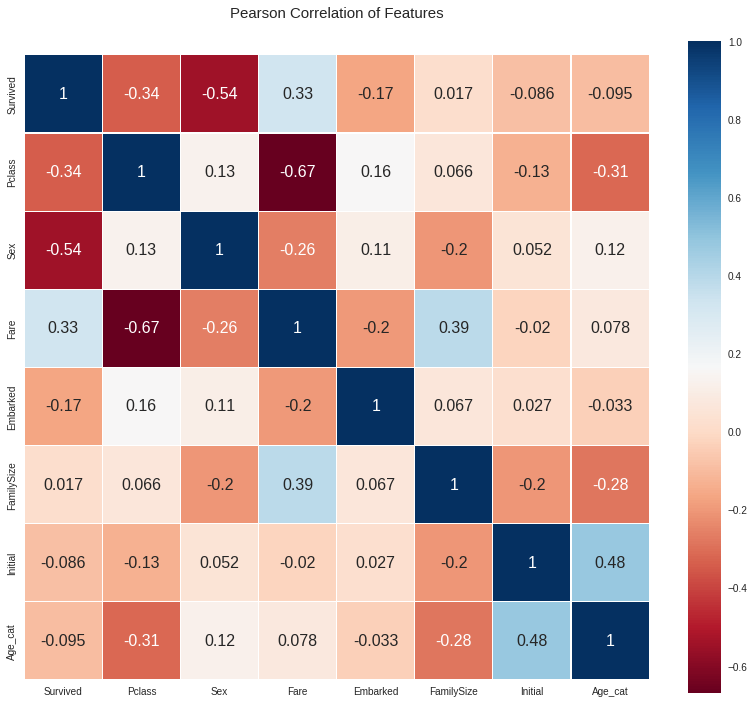

In [25]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":16})

del heatmap_data

* Sex, Pclass, fare, Embarked 와 Survived 에 상관관계가 있음
* 서로 강한 상관관계를 가지는 feature 들은 없음 : redundant feature 없음

## 3.4. Data preprocessing (전처리) - One-hot encoding on Initial and Embarked

* pandas - get_dummies 사용, initial을 prefix로 두어서 구분이 쉽도록 함

In [26]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [27]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [28]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

## 3.5. Drop columns
* 필요한 columns만 남기고 제거

In [29]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis =1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis =1, inplace=True)

In [30]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [31]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1.0,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2.0,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1.0,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1.0,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,2.0,2,0,0,0,1,0,0,0,1


# 4. Building machine learning model and prediction using the trained model
* sklearn : feature engineering, preprocessing, supervised learning, unsupervised learning, model evaluation, pipeline 등 머신러닝 관련 모든 작업들이 구현되어있음

* titanic 은 binary classification 문제

In [35]:
# importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics                               # 모델 평가
from sklearn.model_selection import train_test_split      # training set을 쉽게 나눠주는 함수

## 4.1. Preparation - Split dataset into train, valid, test set

In [33]:
X_train = df_train.drop('Survived', axis =1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [36]:
# train_test_split 사용 , train - valid set 분리

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

## 4.2. Model generation and prediction

* 모델 객체를 만들고 fit method로 학습시킴
* valid set input 을 넣어주어 예측값(생존여부)를 얻음
* 향후 parameter tuning 작업도 필요

In [37]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [39]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.09% 정확도로 생존을 맞춤


## 4.3. Feature importance

* 학습된 모델은 feature importance를 가짐 : 만든 모들이 어떤 feature의 영향을 많이 받았는지 확인할 수 있음

* pandas series 이용하여 sorting 후 그래프 그릴 수 있음

* feature importance를 보고 정확도를 높이기 위해 feature selection을 하거나, 속도를 높이기 위해 feature 를 제거할 수 있음

In [40]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

<function matplotlib.pyplot.show>

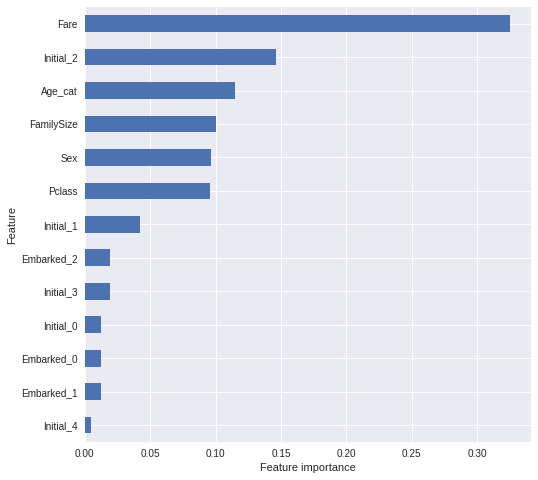

In [41]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show

## 4.4. Prediction on Test Set

In [42]:
submission = pd.read_csv('/content/gdrive/MyDrive/2022-1/휴먼프밍/1차 프로젝트/1주차/gender_submission.csv')

In [43]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [44]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [ ]:
# submission.to_csv('/my_first_submission.csv', index=False)